In [1]:
#subset by longitude to look for local effects
import os
import sys
import matplotlib
import matplotlib.pyplot as plt
import dask.array as da
import dask.dataframe as dd
import xarray as xr
from xnemogcm import open_domain_cfg, get_metrics
import xgcm
import cartopy.crs as ccrs
import cmocean
import numpy as np
from scipy.stats import linregress
import datetime
import pandas as pd
import plots_spatial as pltspat
# Add SouthernDemons library to PATH
sys.path.append(os.path.abspath("../lib/"))
from teos_ten import teos_sigma0
import datesandtime

# Subdomain information (As inputted into TRACMASS, note non-pythonic indexing)
imindom = 1
imaxdom = 1440
jmindom = 1
jmaxdom = 400
kmindom = 1
kmaxdom = 75

# Location of the TRACMASS run
data_dir = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/ORCA025_fwd/")

# Location of the OUTPUT directory created when running SouthernDemons executable
out_dir = os.path.abspath(data_dir + "/OUTPUT.ORCA025_fwd_extra/")
ndense_path = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/SouthernDemons/neutraldensity/output/ORCA025_Dec1982/*.nc" )
# Location of masks and grid information for the model
grid_path = os.path.abspath("/gws/nopw/j04/bas_pog/astyles/ORCA025_fwd/topo" )
grid_files = ['mask.nc','mesh_hgr.nc','mesh_zgr.nc']

cal_months = ["Jan","Feb","Mar","Apr","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

# Use dask to load the tabulated data lazily 
df_ini = dd.read_parquet(out_dir + f"/df_ini.combined.parquet")
#df_out = dd.read_parquet(out_dir + f"/df_out.combined.parquet")
df_vent = dd.read_parquet(out_dir + f"/df_vent.parquet")
ds_domain = open_domain_cfg( datadir=grid_path, files = grid_files )

In [ ]:
len(df_ini)

In [2]:
ds_nd = xr.open_mfdataset(ndense_path, chunks='auto')
nd_coord = ds_nd.sigma_ver.values

def nd_bin_to_density( x ):
    # If x == -1 -> No density surface intersects the fluid column. Retain value of -1
    if x < 0:
        out = -1

    # Otherwise return the neutral density value
    else:
        out = nd_coord[ x - 1 ]

    return out

In [3]:
df_vent['ndense'] = df_vent['nd_bin_ini'].apply(nd_bin_to_density, meta=('sigma_ver',float))


In [4]:
def plot_o(ds_domain, vol_xy, y,vmax=1e3,log=True, cmp =cmocean.cm.thermal ): 
    #print((vol_xy.head(5)))
    da_vol_xy = vol_xy.to_xarray()[y]
    #print(da_vol_xy.head(4))
    # Define coordinates x_c and y_c which are the Pythonic indices rather than the TRACMASS indices. This ensures agreement with the coordinates for ds_domain
  
    da_vol_xy = da_vol_xy.assign_coords( {'x_c':da_vol_xy.binnedx_o-1 , 'y_c':da_vol_xy.binnedy_o - 1} ) 
    da_vol_xy = da_vol_xy.swap_dims({'binnedx_o':'x_c', 'binnedy_o':'y_c'})
    
    # Reorder axes to agree with ds_subdomain
    da_vol_xy = da_vol_xy.transpose("y_c","x_c",...)
    
    
    # Align the coordinates of the grid file with the subdomain in da_vol_xy
    ds_domain_allign, da_vol_xy = xr.align( ds_domain, da_vol_xy )

    fig, ax = plt.subplots(1,1,dpi=200,subplot_kw={'projection':ccrs.SouthPolarStereo()})
    lat = ds_domain_allign.gphit
    lon = ds_domain_allign.glamt
    
    
    
    #vmax = vnorm.max().compute()

    
    vmin=vmax*1e-3    
    if log == True:
        lognorm = matplotlib.colors.LogNorm(vmax = vmax, vmin = vmax /1e3 )
        cax = ax.pcolormesh( lon, lat, da_vol_xy, transform=ccrs.PlateCarree(), cmap=cmp, norm=lognorm )
    else:
        cax = ax.pcolormesh( lon, lat,  da_vol_xy, transform=ccrs.PlateCarree(), cmap=cmp)
    ax.coastlines()
    fig.colorbar(cax)
    return fig ,ax

In [5]:
def plot_i(ds_domain, vol_xy, y,vmax=1e3,log=True, cmp =cmocean.cm.thermal ): 
    #print((vol_xy.head(5)))
    da_vol_xy = vol_xy.to_xarray()[y]
    #print(da_vol_xy.head(4))
    # Define coordinates x_c and y_c which are the Pythonic indices rather than the TRACMASS indices. This ensures agreement with the coordinates for ds_domain
  
    da_vol_xy = da_vol_xy.assign_coords( {'x_c':da_vol_xy.binnedx_i-1 , 'y_c':da_vol_xy.binnedy_i - 1} ) 
    da_vol_xy = da_vol_xy.swap_dims({'binnedx_i':'x_c', 'binnedy_i':'y_c'})
    
    # Reorder axes to agree with ds_subdomain
    da_vol_xy = da_vol_xy.transpose("y_c","x_c",...)
    
    
    # Align the coordinates of the grid file with the subdomain in da_vol_xy
    ds_domain_allign, da_vol_xy = xr.align( ds_domain, da_vol_xy )

    fig, ax = plt.subplots(1,1,dpi=200,subplot_kw={'projection':ccrs.SouthPolarStereo()})
    lat = ds_domain_allign.gphit
    lon = ds_domain_allign.glamt
    
    
    
    #vmax = vnorm.max().compute()

    
    vmin=vmax*1e-3    
    if log == True:
        lognorm = matplotlib.colors.LogNorm(vmax = vmax, vmin = vmax /1e3 )
        cax = ax.pcolormesh( lon, lat, da_vol_xy, transform=ccrs.PlateCarree(), cmap=cmp, norm=lognorm )
    else:
        cax = ax.pcolormesh( lon, lat,  da_vol_xy, transform=ccrs.PlateCarree(), cmap=cmp)
    ax.coastlines()
    fig.colorbar(cax)
    return fig ,ax

In [6]:
def plot_seed(d_min,d_max):
    df_densest = df_vent[(df_vent['ndense']>d_min) &(df_vent['ndense']<d_max) ][['binnedx_i','binnedy_i','ndense','year_o']]
    df_densest= df_densest[df_densest['year_o']>1983]
    df_group = df_densest.groupby(['binnedx_i','binnedy_i'])
    count = df_group.count().compute()
    plot_i(ds_domain,count,'ndense',log=False)

def plot_vent(d_min,d_max):
    df_densest = df_vent[(df_vent['ndense']<d_max) &(df_vent['ndense']>d_min) ][['binnedx_o','binnedy_o','subvol_o','year_o']]
    df_densest= df_densest[df_densest['year_o']>1983]
    df_group = df_densest.groupby(['binnedx_o','binnedy_o'])
    count = df_group.sum('subvol_o').compute()
    plot_o(ds_domain,count,'subvol_o',vmax=1e12)
def plot_depth(d_min,d_max):
    cmp =cmocean.cm.thermal 
    df_densest = df_vent[(df_vent['ndense']<d_max) &(df_vent['ndense']>d_min) ][['binnedz_i','binnedy_i','subvol_i','year_o']]
    df_densest= df_densest[df_densest['year_o']>1983]
    df_group = df_densest.groupby(['binnedy_i','binnedz_i'])
    count = df_group.sum('subvol_i').compute()
    count = count.reset_index()

# Pivot the DataFrame to get a 2D grid
    grid = count.pivot(index="binnedz_i", columns="binnedy_i", values="subvol_i")
    
    # Extract the X, Y meshgrid from index and columns
    yy, zz = np.meshgrid(grid.columns, grid.index)
    
    # Extract the Z values (subvol_i) ensuring correct shape
    Z = grid.values
    
    fig, ax = plt.subplots(1, 1, dpi=200, subplot_kw={'projection': ccrs.PlateCarree()})
    
    cax = ax.pcolormesh(yy, zz, Z, transform=ccrs.PlateCarree(), cmap=cmp)
    
    plt.colorbar(cax, ax=ax, label="Subvol_i")
    plt.show()

In [ ]:
#### location of no neut density surfaces

In [11]:
df_none = df_vent[df_vent['ndense']==-1][['binnedx_i','binnedy_i','ndense','z_i']]
df_group = df_none.groupby(['binnedx_i','binnedy_i'])
count = df_group.count().compute()


(<Figure size 1280x960 with 2 Axes>, <GeoAxes: >)

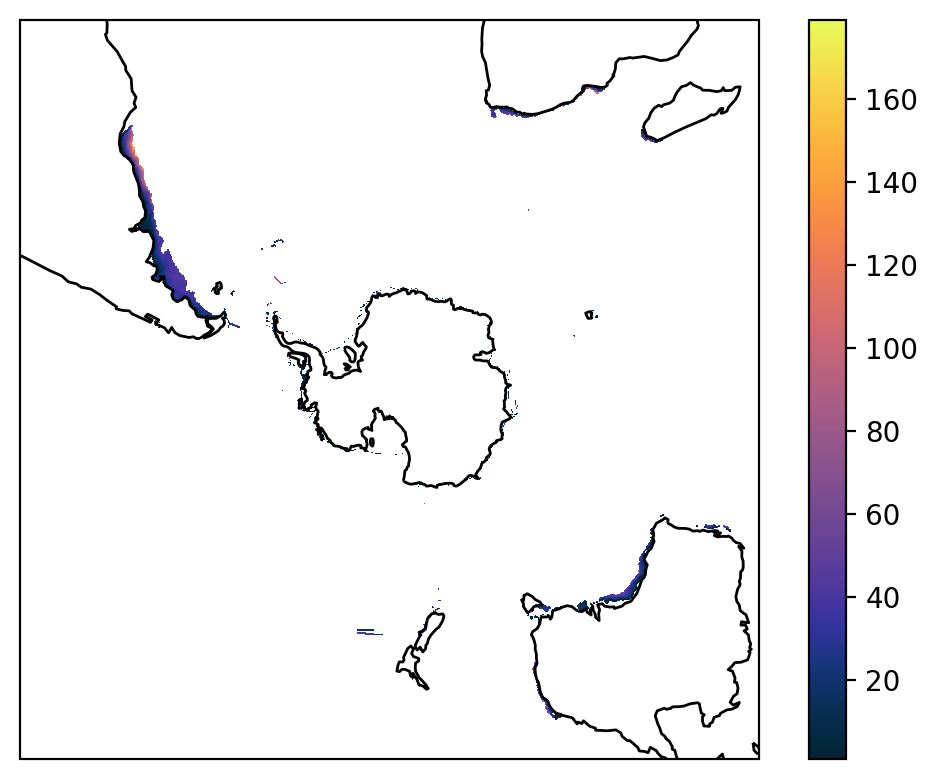

In [34]:
plot_i(ds_domain,count,'ndense',log=False)

In [142]:
########
#now isolate trajectories with  ndense >1028
df_densest = df_vent[df_vent['ndense']>1027.8][['binnedx_i','binnedy_i','ndense','z_i','year_o']]
df_densest= df_densest[df_densest['year_o']>1983]
df_group = df_densest.groupby(['binnedx_i','binnedy_i'])
count = df_group.count().compute()


(<Figure size 1280x960 with 2 Axes>, <GeoAxes: >)

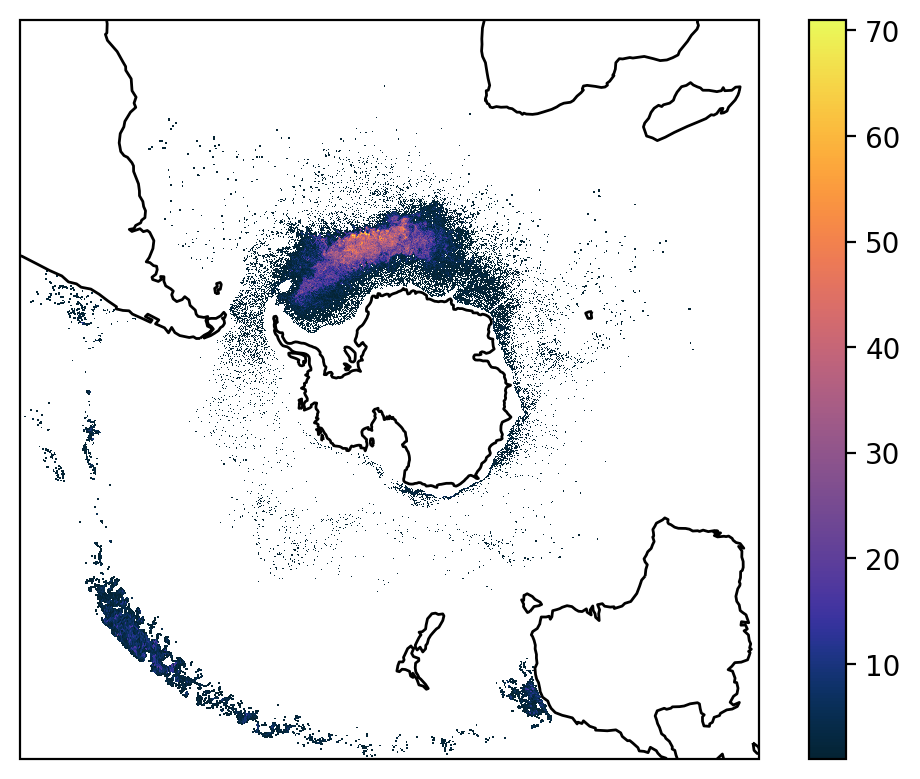

In [143]:
plot_i(ds_domain,count,'ndense',log=False)

In [47]:

df_group = df_densest.groupby(['binnedx_i','binnedy_i'])
count = df_group.mean('z_i').compute()


(<Figure size 1280x960 with 2 Axes>, <GeoAxes: >)

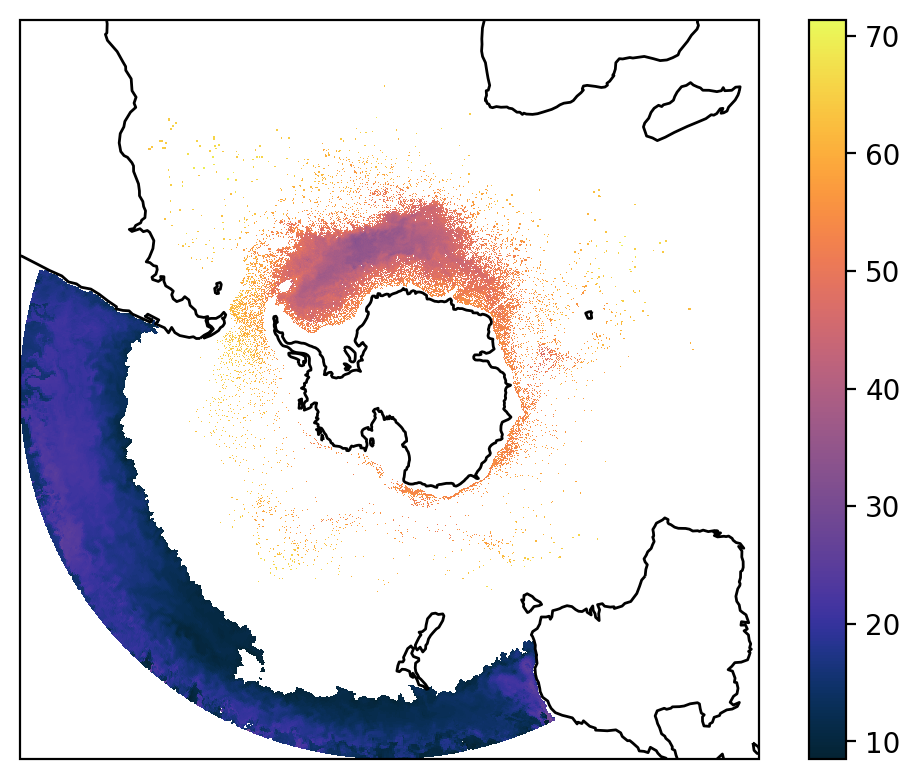

In [48]:
plot_i(ds_domain,count,'z_i',log=False)

In [50]:
df_densest = df_vent[df_vent['ndense']>1027.8][['binnedx_o','binnedy_o','subvol_o']]
df_group = df_densest.groupby(['binnedx_o','binnedy_o'])
count = df_group.sum('subvol_o').compute()

(<Figure size 1280x960 with 2 Axes>, <GeoAxes: >)

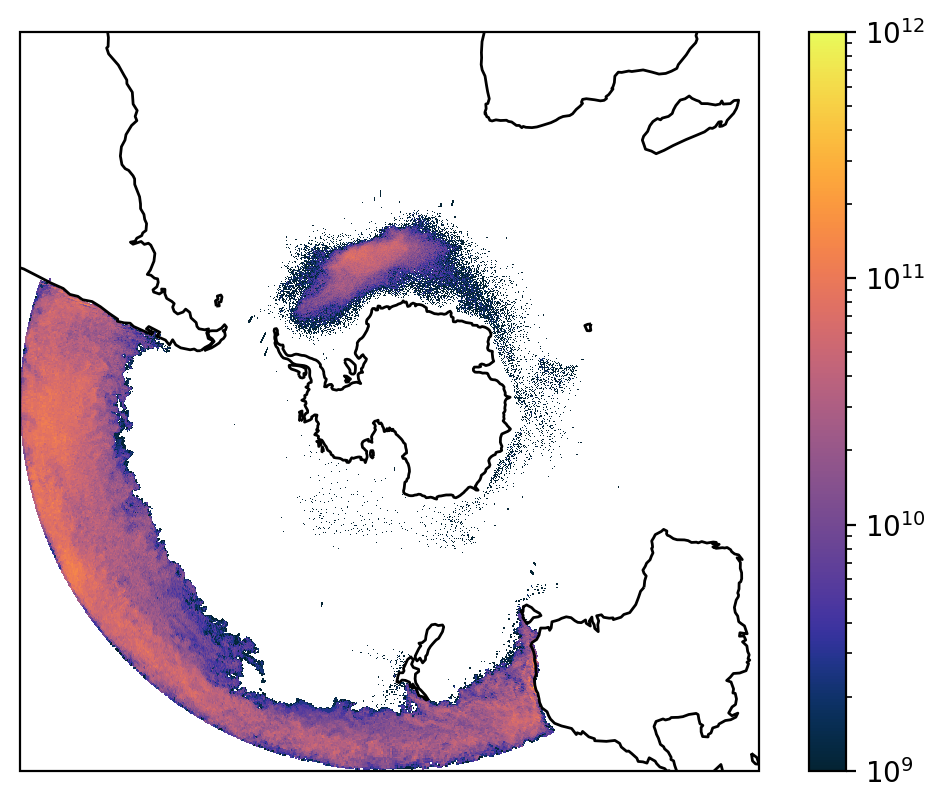

In [52]:
plot_o(ds_domain,count,'subvol_o',vmax=1e12)

In [155]:
#####try to isolate gyre
df_densest = df_vent[(df_vent['ndense']>1027.8) &(df_vent['ndense']<1028) ][['binnedx_i','binnedy_i','ndense','year_o']]
df_densest= df_densest[df_densest['year_o']>1983]
df_group = df_densest.groupby(['binnedx_i','binnedy_i'])
count = df_group.count().compute()


(<Figure size 1280x960 with 2 Axes>, <GeoAxes: >)

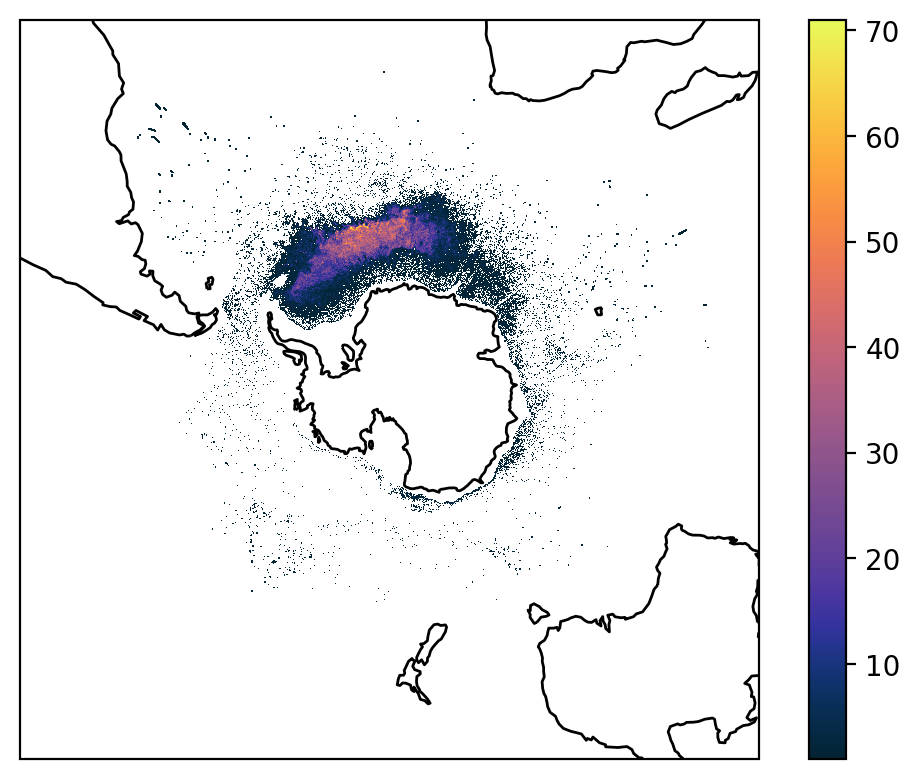

In [156]:
plot_i(ds_domain,count,'ndense',log=False)

In [158]:
df_densest = df_vent[(df_vent['ndense']>1027.8) &(df_vent['ndense']<1028) ][['binnedx_o','binnedy_o','subvol_o','year_o']]
df_densest= df_densest[df_densest['year_o']>1983]
df_group = df_densest.groupby(['binnedx_o','binnedy_o'])
count = df_group.sum('subvol_o').compute()

(<Figure size 1280x960 with 2 Axes>, <GeoAxes: >)

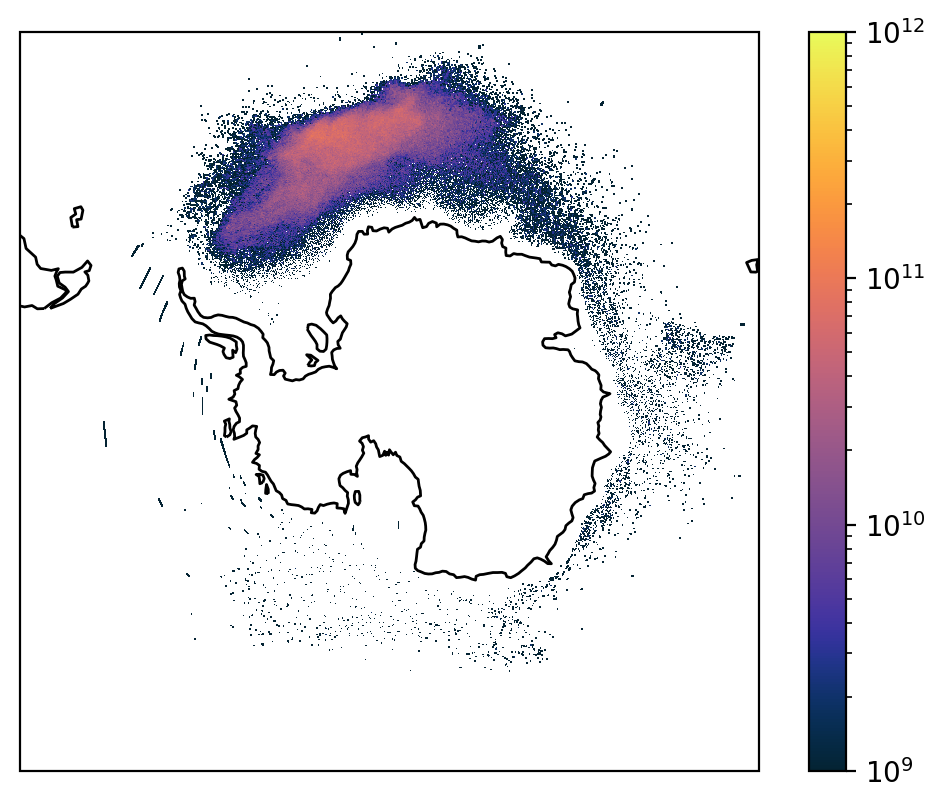

In [159]:
plot_o(ds_domain,count,'subvol_o',vmax=1e12)

In [ ]:
######

In [182]:
df_densest = df_vent[(df_vent['ndense']>1027.1) &(df_vent['ndense']<1027.2) ][['binnedx_i','binnedy_i','ndense','year_o']]
df_group = df_densest.groupby(['binnedx_i','binnedy_i'])
count = df_group.count().compute()

(<Figure size 1280x960 with 2 Axes>, <GeoAxes: >)

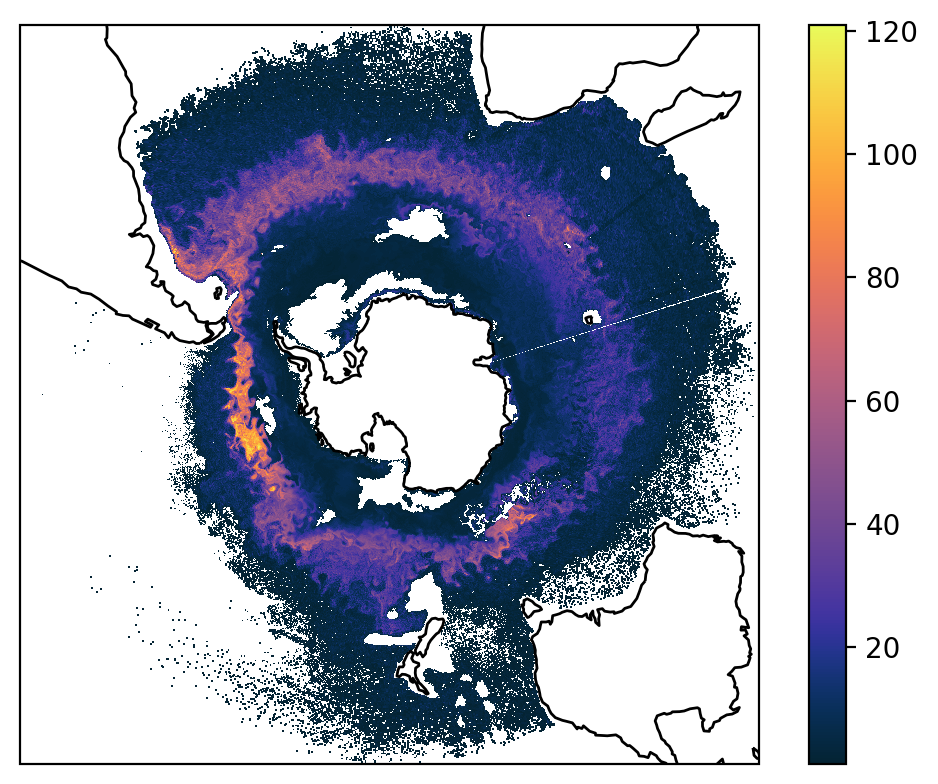

In [183]:
plot_i(ds_domain,count,'ndense',log=False)

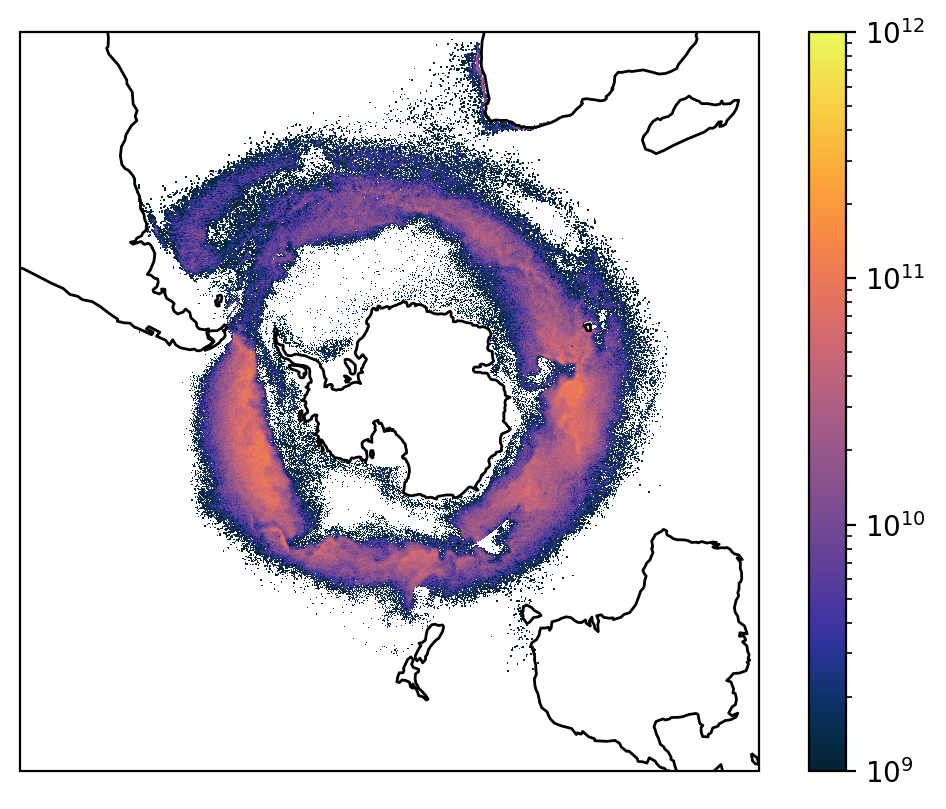

In [188]:
plot_vent(1027.1,1027.2)

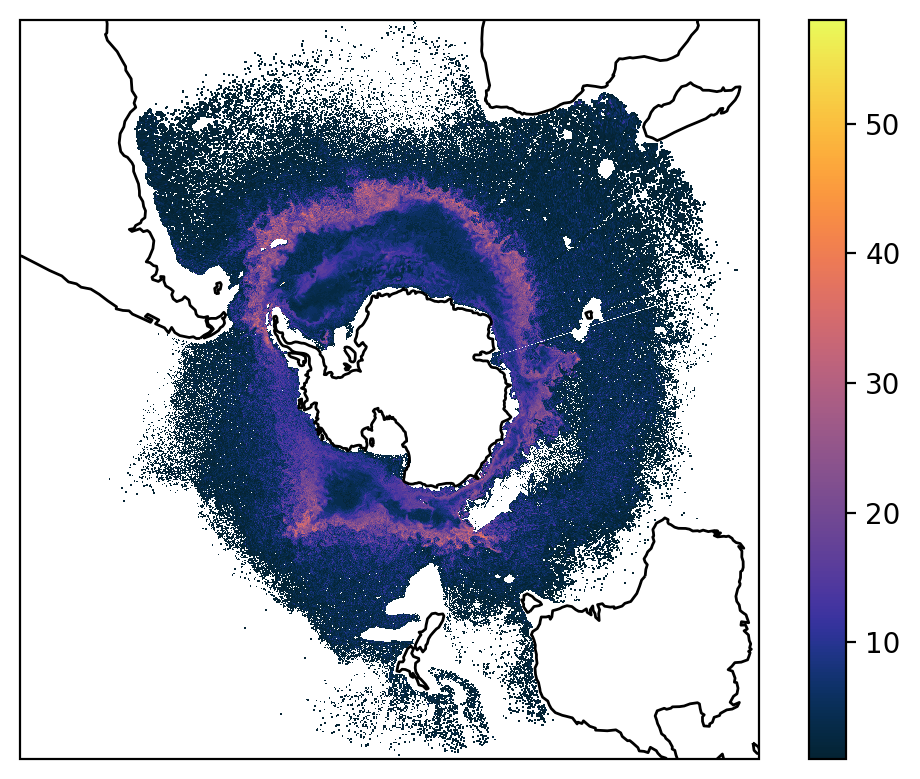

In [190]:
plot_seed(1027.4,1027.5)

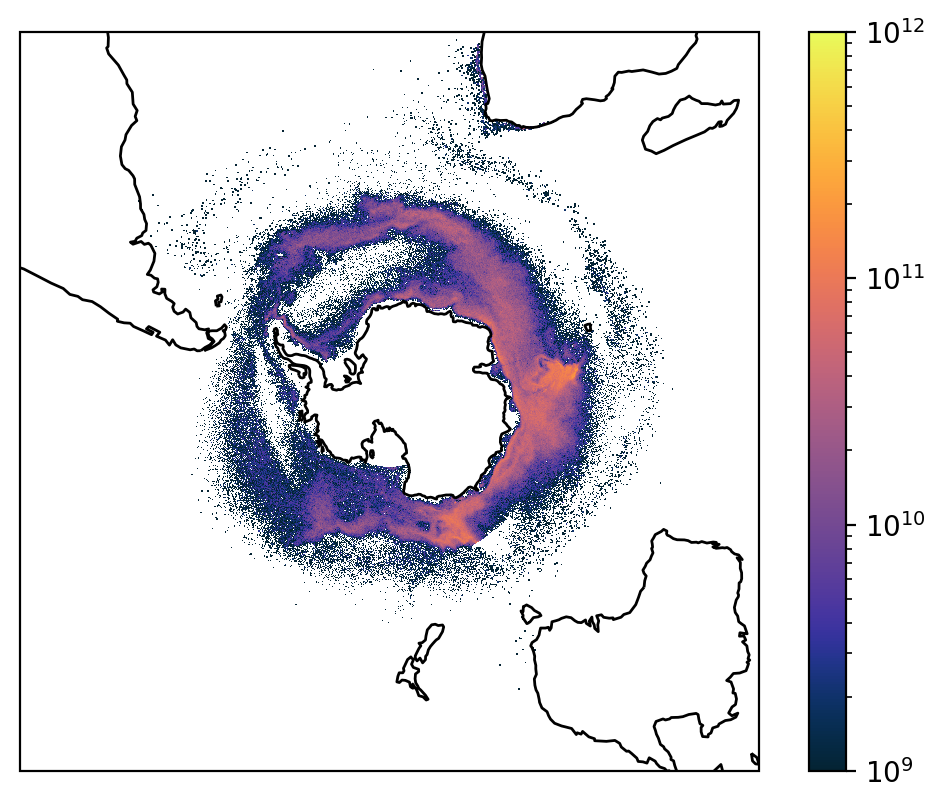

In [189]:
plot_vent(1027.4,1027.5)

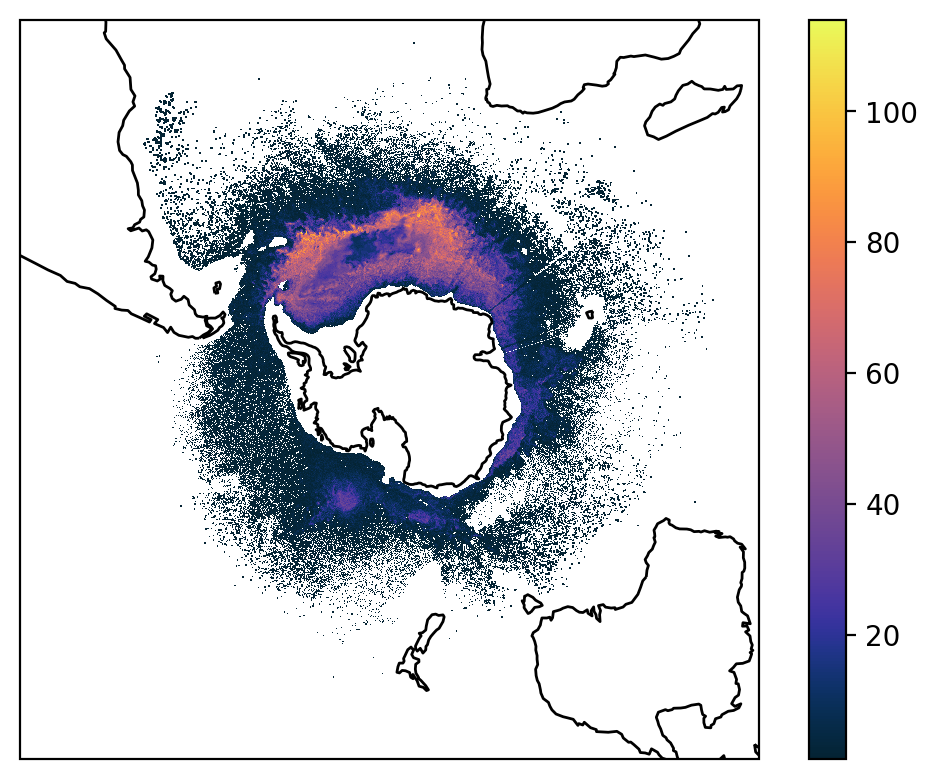

In [11]:
plot_seed(1027.7,1027.8)

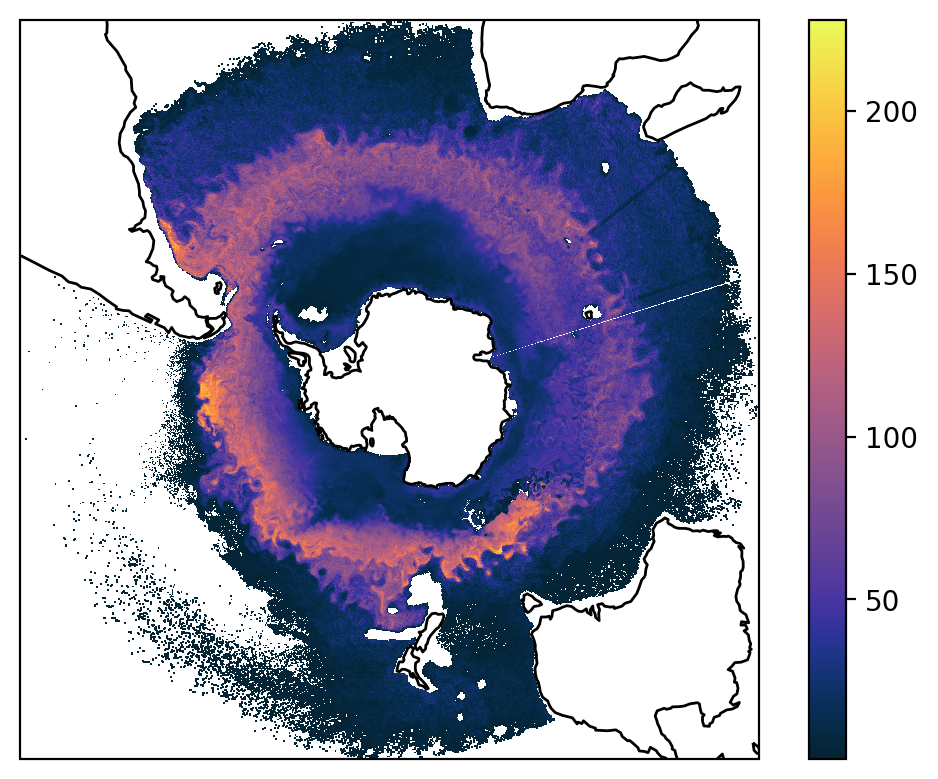

In [8]:
plot_seed(1026.9,1027.4)

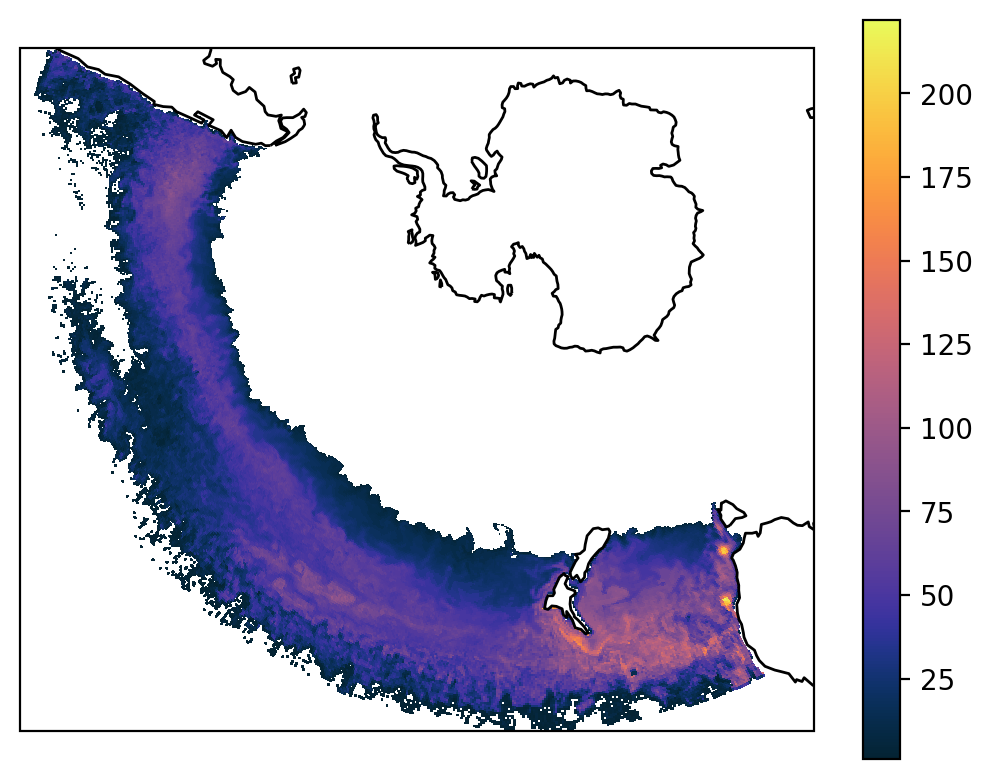

In [17]:
plot_seed(1025.1,1026.2)

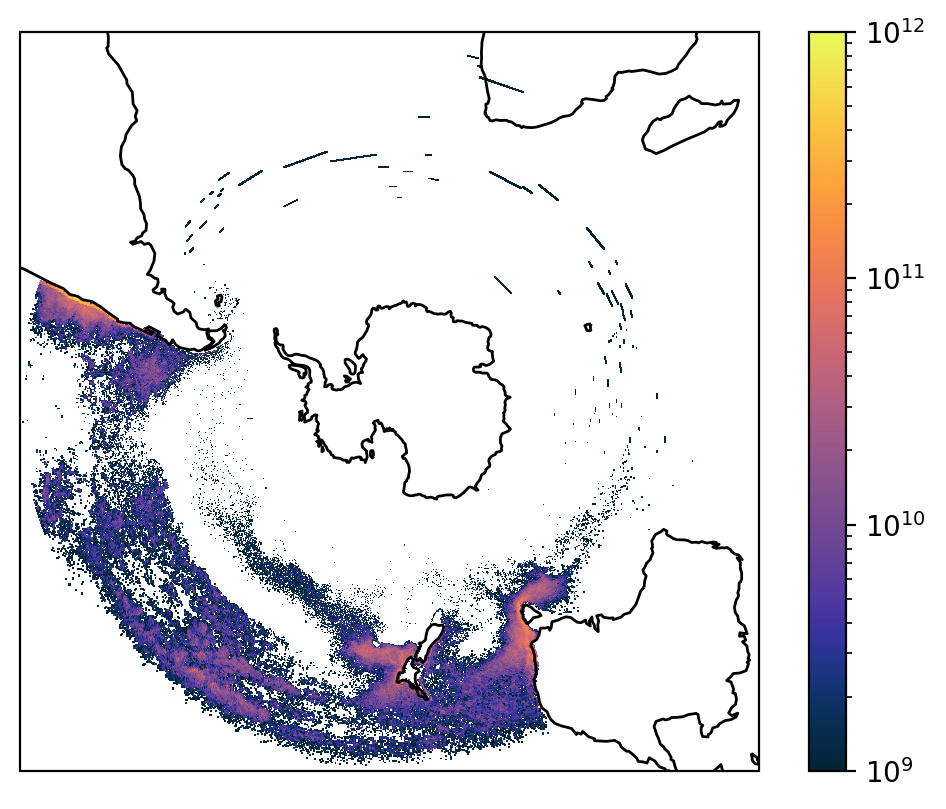

In [25]:
plot_vent(1025.1,1026.3)

In [22]:
df_densest = df_vent[(df_vent['ndense']>1025) &(df_vent['ndense']<1026.2) ][['binnedx_i','binnedy_i','ndense','z_i','year_o']]
df_densest= df_densest[df_densest['year_o']>1983]
df_group = df_densest.groupby(['binnedx_i','binnedy_i'])
count = df_group.count().compute()



In [23]:

df_group = df_densest.groupby(['binnedx_i','binnedy_i'])
count = df_group.mean('z_i').compute()

(<Figure size 1280x960 with 2 Axes>, <GeoAxes: >)

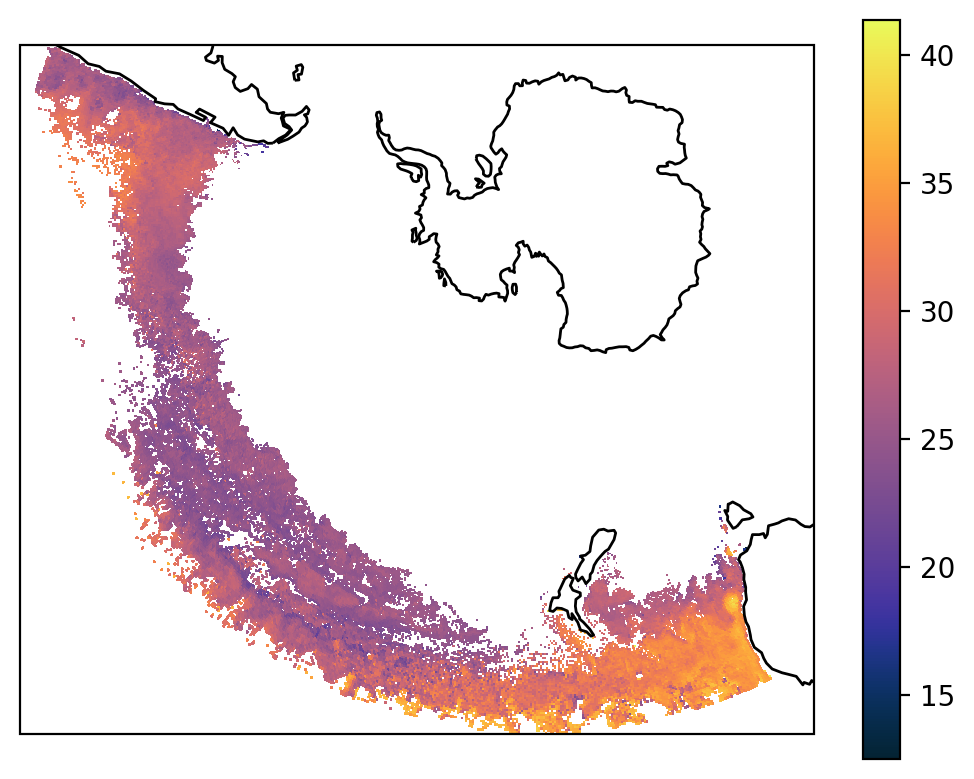

In [24]:
plot_i(ds_domain,count,'z_i',log=False)

In [53]:
df_densest = df_vent[df_vent['ndense']>1027.8]
df_group= df_densest.groupby('ndense')
dens = df_group.mean('density_o').compute()

dens = dens.reset_index()
dens=dens.sort_values('ndense')

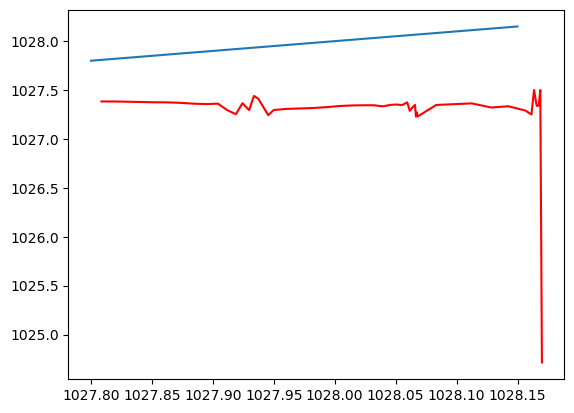

In [55]:
plt.plot(dens['ndense'],1000+dens['density_o'],c='red')
plt.plot([1027.8,1028.15],[1027.8,1028.15])

In [162]:
#############
# now look at range 1027.5 to 1027.8
df_densest = df_vent[(df_vent['ndense']<1026.9) &(df_vent['ndense']>1026.35) ][['binnedx_i','binnedy_i','ndense','year_o']]
df_densest= df_densest[df_densest['year_o']>1983]
df_group = df_densest.groupby(['binnedx_i','binnedy_i'])
count = df_group.count().compute()


(<Figure size 1280x960 with 2 Axes>, <GeoAxes: >)

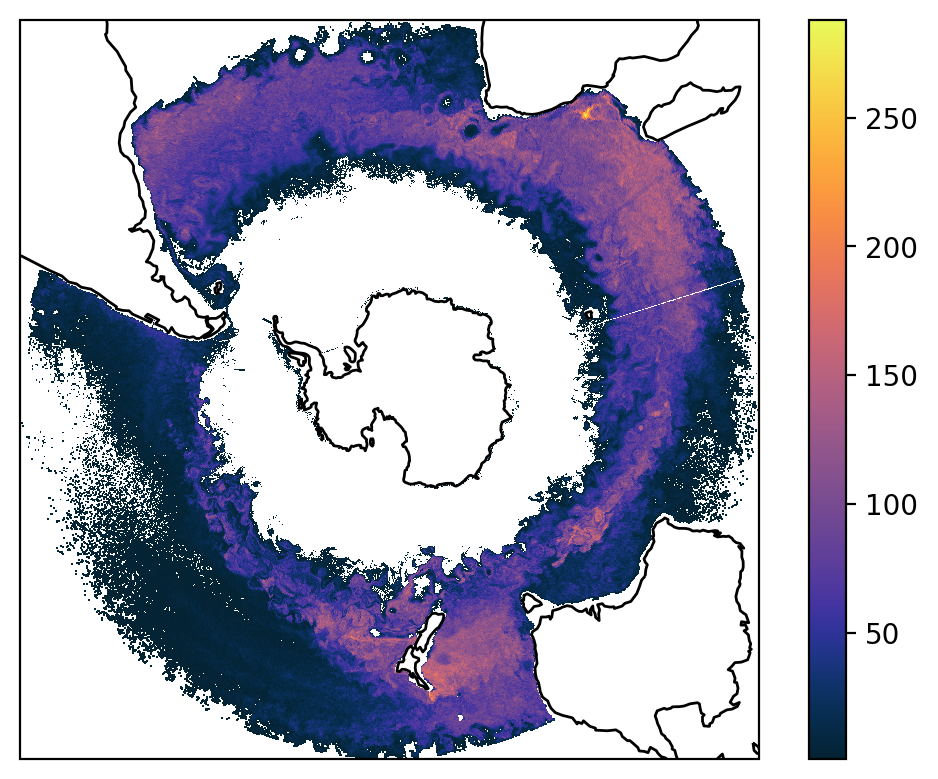

In [163]:
plot_i(ds_domain,count,'ndense',vmax=1e12,log=False)

In [171]:
df_densest = df_vent[(df_vent['ndense']<1026.9) &(df_vent['ndense']>1026.35) ][['binnedx_o','binnedy_o','subvol_o','year_o']]
df_densest= df_densest[df_densest['year_o']>1983]
df_group = df_densest.groupby(['binnedx_o','binnedy_o'])
count = df_group.sum('subvol_o').compute()


(<Figure size 1280x960 with 2 Axes>, <GeoAxes: >)

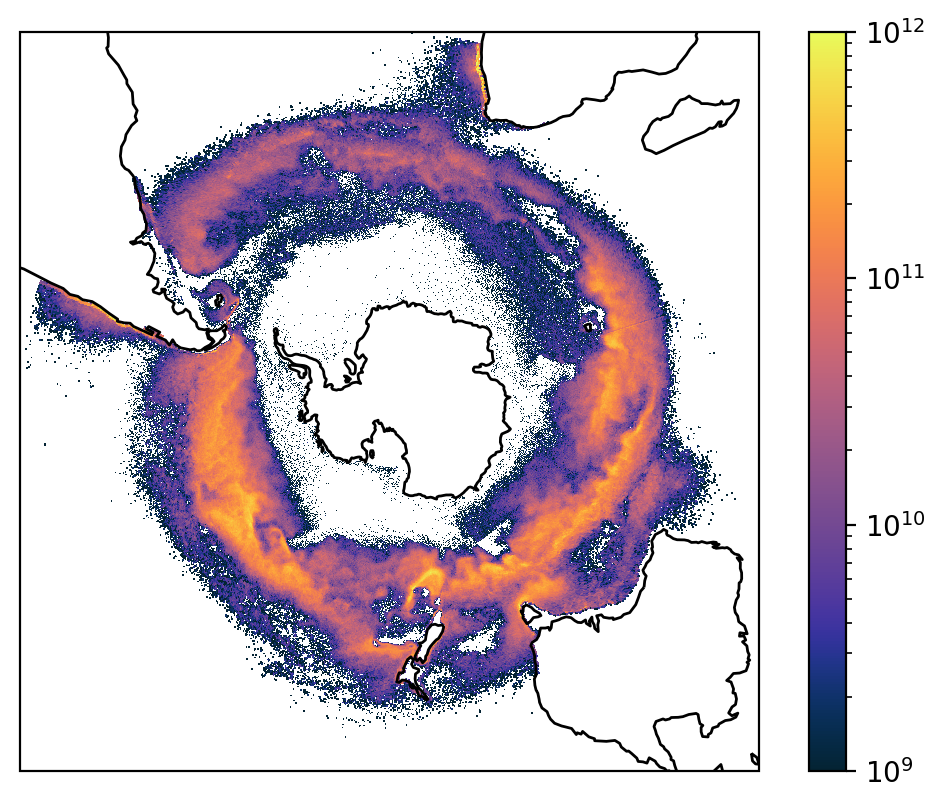

In [172]:
plot_o(ds_domain,count,'subvol_o',vmax=1e12)

In [151]:
df_densest = df_vent[(df_vent['ndense']>1025.5) &(df_vent['ndense']<1028.3)]
df_group= df_densest.groupby('ndense')
dens = df_group.mean('density_o').compute()

dens = dens.reset_index()
dens=dens.sort_values('ndense')

Text(0, 0.5, 'density out')

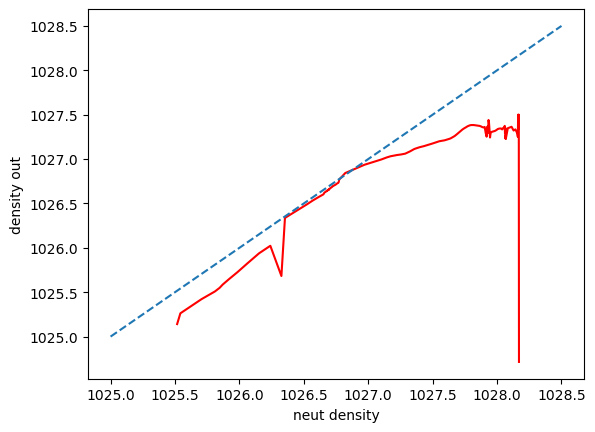

In [152]:
plt.plot(dens['ndense'],1000+dens['density_o'],c='red')
plt.plot([1025,1028.5],[1025,1028.5],ls='--')
plt.xlabel('neut density')
plt.ylabel('density out')

(1027.0, 1028.3)

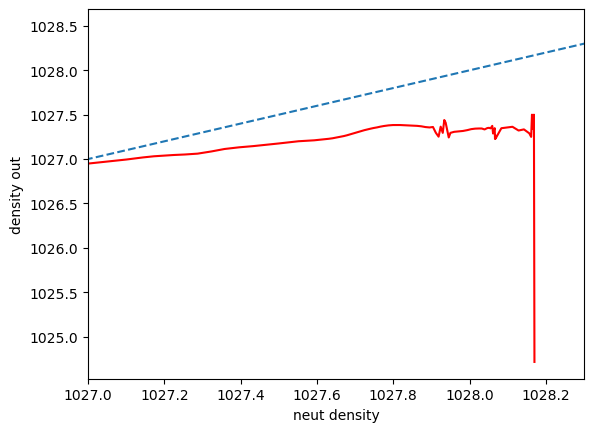

In [170]:
plt.plot(dens['ndense'],1000+dens['density_o'],c='red')
plt.plot([1025,1028.5],[1025,1028.5],ls='--')
plt.xlabel('neut density')
plt.ylabel('density out')
plt.xlim(1027.,1028.3)

In [ ]:
### make nicer plots


In [14]:
df_densest = df_vent[(df_vent['ndense']>1025.5) &(df_vent['ndense']<1028.3)]
df_group= df_densest.groupby('ndense')
dens = df_group.mean('density_o').compute()

dens = dens.reset_index()
dens=dens.sort_values('ndense')

mins = df_group.min('density_o').compute()
mins=mins.sort_values('ndense')
mins = mins.reset_index()

maxs = df_group.max('density_o').compute()
maxs=maxs.sort_values('ndense')
maxs = maxs.reset_index()

NameError: name 'yr_group' is not defined

In [15]:
maxs = df_group.max('density_o').compute()
maxs=maxs.sort_values('ndense')
maxs = maxs.reset_index()

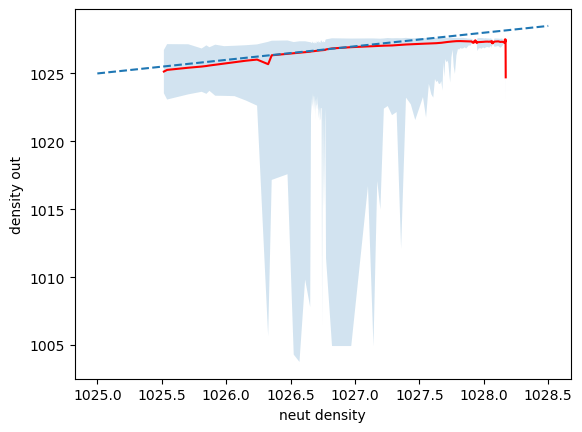

In [16]:
plt.plot(dens['ndense'],1000+dens['density_o'],c='red')
plt.plot([1025,1028.5],[1025,1028.5],ls='--')
plt.xlabel('neut density')
plt.ylabel('density out')
plt.fill_between(maxs.ndense,1000+mins.density_o,1000+maxs.density_o, alpha=0.2)

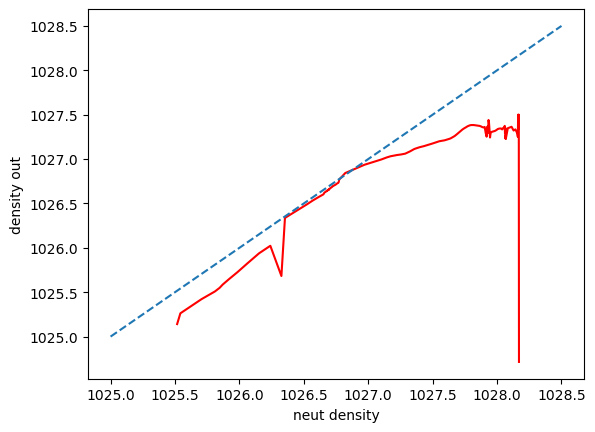

In [17]:
plt.plot(dens['ndense'],1000+dens['density_o'],c='red')
plt.plot([1025,1028.5],[1025,1028.5],ls='--')
plt.xlabel('neut density')
plt.ylabel('density out')
plt.savefig('../fig/Density_classes/all_densities.png')

ValueError: not enough values to unpack (expected 2, got 1)

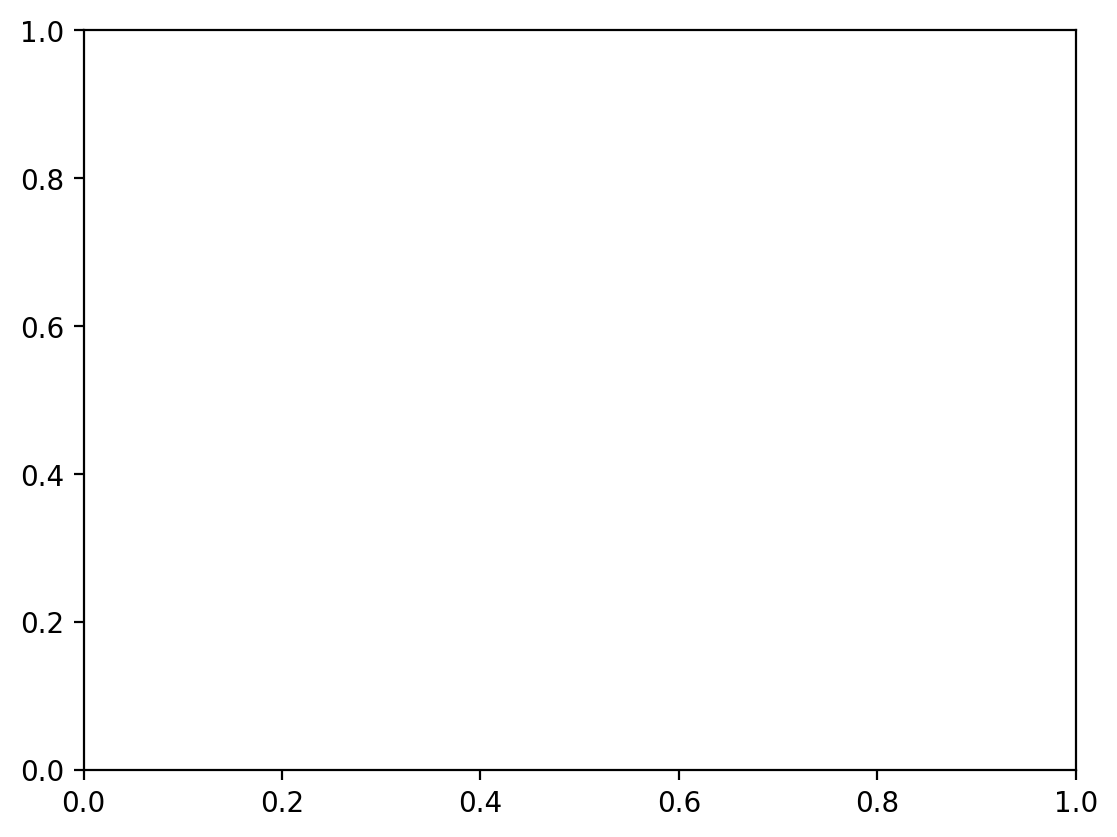

In [23]:
classes = [[1028,1029],[1027.8,1028],[1027.4,1027.8],[1026.9,1027.4],[1026.35,1026.9],[1025,1026.35]]
df_densest = df_vent[(df_vent['ndense']>1025.5) &(df_vent['ndense']<1028.3)]
df_densest=df_densest[df_densest['year_o']>1983]

for clas in classes:
    '''
    plot_seed(clas[0],clas[1])
    plt.title(f'seeding_location_{clas[0]}_to_{clas[1]}')
    plt.savefig(f'../fig/Density_classes/late/seeding_{clas[0]}_to_{clas[1]}.png')
    plot_vent(clas[0],clas[1])
    plt.title(f'ventilation_location_{clas[0]}_to_{clas[1]}')
    plt.savefig(f'../fig/Density_classes/late/ventialtion_{clas[0]}_to_{clas[1]}.png')
    '''
    plot_depth(clas[0],clas[1])

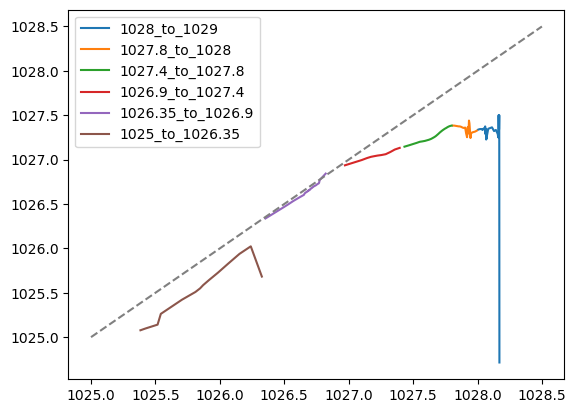

In [27]:
for clas in classes:
    df_densest = df_vent[(df_vent['ndense']>clas[0]) &(df_vent['ndense']<clas[1])]
    df_group= df_densest.groupby('ndense')
    dens = df_group.mean('density_o').compute()
    dens = dens.reset_index()
    dens=dens.sort_values('ndense')
    plt.plot(dens['ndense'],1000+dens['density_o'],label = f'{clas[0]}_to_{clas[1]}')
plt.plot([1025,1028.5],[1025,1028.5],ls='--',c='grey')
plt.legend()
plt.savefig('../fig/Density_classes/densities_classified.png')

    

In [ ]:
######
#look at the densities of the deep

In [97]:
sum_z = np.array(ds_domain.e3t_1d['gdept_1d'])
z_index = np.array(ds_domain.e3t_1d['z_c'])
cell_z = np.append(np.array(da.diff(ds_domain.e3t_1d['gdept_1d'])),0)
df_sum_in = dd.from_dict({'bin_depth_i':sum_z,'binnedz_i':z_index, 'cell_h_i':cell_z},npartitions =3)
df_merge_in = df_vent.merge(df_sum_in,on = 'binnedz_i')
df_merge_in['depth_i'] = (df_merge_in['bin_depth_i'] - da.floor(df_merge_in['bin_depth_i']))* df_merge_in['cell_h_i'] + df_merge_in['bin_depth_i']

In [99]:
df_deep = df_merge_in[df_merge_in['depth_i']>2100]


In [100]:

df_group= df_deep.groupby('ndense')
dens = df_group.mean('density_o').compute()

dens = dens.reset_index()
dens=dens.sort_values('ndense')

Text(0, 0.5, 'density out')

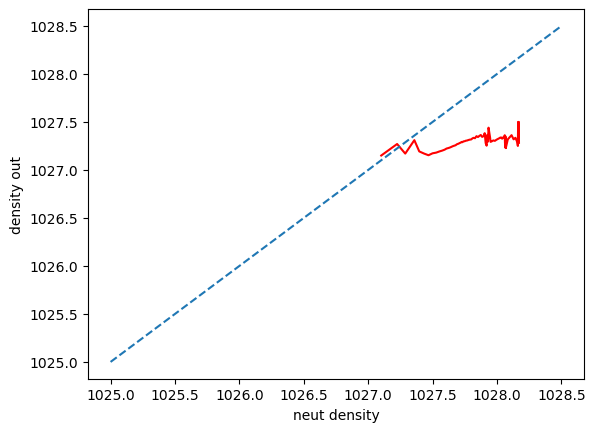

In [101]:
plt.plot(dens['ndense'],1000+dens['density_o'],c='red')
plt.plot([1025,1028.5],[1025,1028.5],ls='--')
plt.xlabel('neut density')
plt.ylabel('density out')
plt.savefig('../fig/Deep_water/densities.png')


In [106]:

yr_group  = df_deep[['year_o','z_o']].groupby('year_o') 
count = yr_group.count().compute()


count = count.sort_values('year_o')
count = count.reset_index()

<BarContainer object of 30 artists>

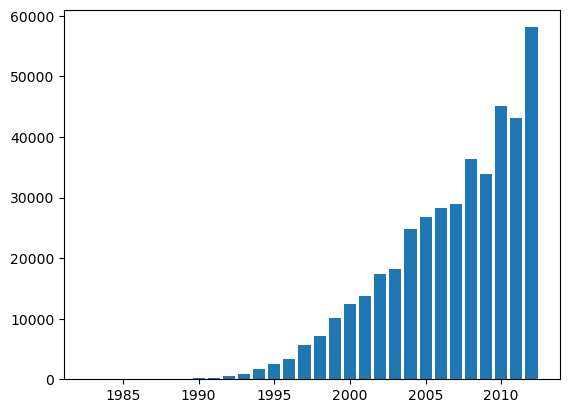

In [119]:

plt.bar(count['year_o'],count['z_o'])

In [120]:

yr_group  = df_deep[['year_o','ndense']].groupby('year_o') 
count = yr_group.mean('ndense').compute()


count = count.sort_values('year_o')
count = count.reset_index()

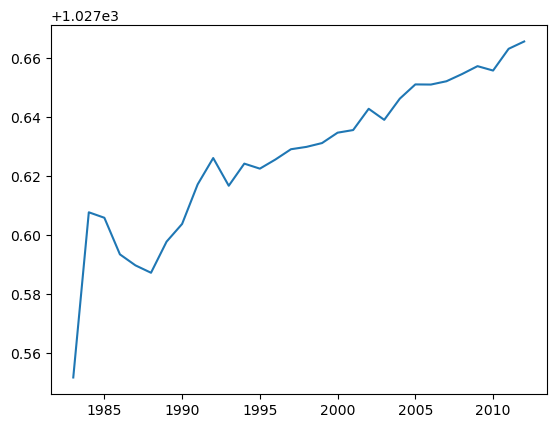

In [127]:
plt.plot(count.year_o,count.ndense)
plt.ylabel('neut dense')

In [ ]:
mins = yr_group.min('ndense').compute()
mins=mins.sort_values('year_o')
mins = mins.reset_index()

maxs = yr_group.max('ndense').compute()
maxs=maxs.sort_values('year_o')
maxs = maxs.reset_index()


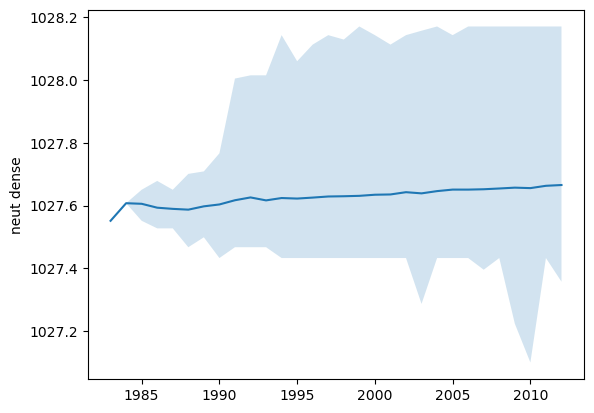

In [130]:
plt.plot(count.year_o,count.ndense)
plt.ylabel('neut dense')
plt.fill_between(maxs.year_o,mins.ndense,maxs.ndense, alpha=0.2)
